# Adaptive Conformal Inference

Implementing the ideas from the paper *Adaptive Conformal Inference Under Distribition Shift* ([Gibbs, 2021](https://arxiv.org/pdf/2106.00170)). The paper was extended with an online multi-expert approach which can adaptively tune the parameter $\gamma$ - will leave that for now.

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from crl.graph_utils import despine
from distrax import Normal

In [16]:
# For the data generation, we'll copy the scheme in Gibbs 2024 using a normal distribution. 
# The predictor will predict a centred Gaussian, so we'll use that to form quantiles. The generating process
# is a std=1 Gaussian, with a time-varying mean mu_t
NUM_STEPS = 10_000
MU_SMOOTH_AMP = 0.006
SEED = 15
gamma = 0.005

key = jax.random.key(SEED)
alpha = 0.1
predictor = Normal(0, 1)

def std_radius(p: float) -> jax.Array:
    """
    Convert central coverage p (0 < p < 1) into ±n standard deviations
    for a standard normal. Vectorised for arbitrary-shape arrays.
    """
    p: jax.Array = jnp.asarray(p)
    if jnp.any((p <= 0) | (p >= 1)):
        raise ValueError("p must lie strictly between 0 and 1")
    return jnp.sqrt(2.0) * jax.scipy.special.erfinv(p)


def true_coverage(mu: jax.Array, qhat: jax.Array) -> jax.Array:
    """
    Exact P(|X| ≤ qhat) when X ~ N(mu, 1).
    """
    upper = qhat - mu
    lower = -qhat - mu
    return jax.scipy.special.ndtr(upper) - jax.scipy.special.ndtr(lower)

mu_t = 0
alpha = 0.2
alpha_t = alpha

mus, xs, scores, alphas, errs, covs = [], [], [], [], [], []
mus.append(mu_t)
alphas.append(alpha_t)
for t in range(NUM_STEPS):
    key, x_sk, mu_sk = jax.random.split(key, 3)

    mu_t = Normal(mu_t, MU_SMOOTH_AMP).sample(seed=mu_sk)
    x_t = Normal(mu_t, 1).sample(seed=x_sk)

    # If the sampled value falls within our prediction set, error is 0, otherwise it's 1
    qhat_t = std_radius(1 - alpha_t) # gives the prediction set [-qhat, +qhat]
    err = jnp.astype(jnp.abs(x_t) >= qhat_t, jnp.int32)
    alpha_t = alpha_t + gamma * (alpha - err)

    coverage = true_coverage(mu_t, qhat_t)
    covs.append(coverage)
    errs.append(err)
    mus.append(mu_t)
    xs.append(x_t)
    alphas.append(alpha_t)

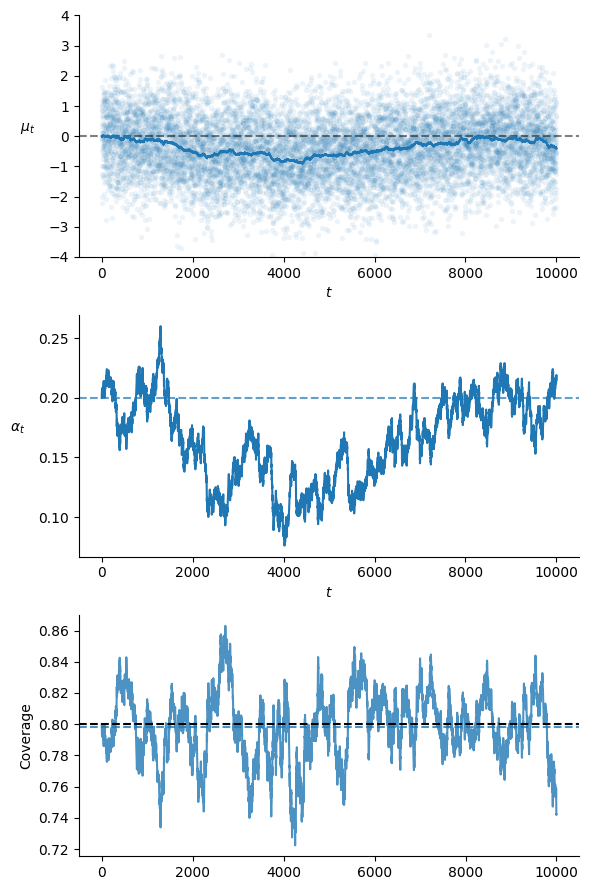

In [17]:
import matplotlib.pyplot as plt

# assume mus, xs, NUM_STEPS, alphas are already defined

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 9))

# --- Top plot ---
ax1.plot(mus, zorder=5)
ax1.scatter(range(NUM_STEPS), xs, s=15, alpha=0.08, linewidths=0)

# move title into y-axis label
ax1.set_ylabel(r'$\mu_t$', rotation=0, labelpad=15)
ax1.set_xlabel(r'$t$')
ax1.set_ylim(-4, 4)
ax1.axhline(0, color='k', linestyle='--', alpha=0.5)
# despine
despine(ax1)

# --- Middle plot ---
ax2.plot(alphas)
ax2.set_ylabel(r'$\alpha_t$', rotation=0, labelpad=15)
ax2.set_xlabel(r'$t$')
ax2.axhline(alpha, color='k', linestyle='--', alpha=0.7, c='tab:blue')
despine(ax2)

# --- Lower plot ---
ax3.plot(covs, label='Time-step coverage', alpha=0.8)
ax3.axhline(y=1 - alpha, label='Desired coverage', c='k', linestyle='--')
ax3.axhline(y=np.mean(covs), label='Mean coverage', linestyle='--', alpha=0.8)
ax3.set_ylabel('Coverage')
despine(ax3)
# plt.legend()
fig.tight_layout()
plt.show()